# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [5]:
# transform 정의

CIFAR_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

## 데이터 로드 및 확인

In [6]:
# datasets

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=CIFAR_transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',train=False,
    download=True, transform=CIFAR_transform
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [8]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

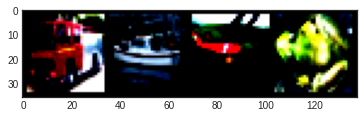

truck	 ship	 plane	 frog	


In [18]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [10]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1=nn.Conv2d(3,32,3,1,1) #(3,32,32)->(32,32,32)
      self.batchnorm1=nn.BatchNorm2d(32)
      self.relu1=nn.ReLU()
      self.maxpool1=nn.MaxPool2d(2) #(32,16,16)
      
      self.conv2=nn.Conv2d(32,64,3,1,1) #(64,16,16)
      self.batchnorm2=nn.BatchNorm2d(64)
      self.relu2=nn.ReLU()
      self.maxpool2=nn.MaxPool2d(2) #(64,8,8)

      self.conv3=nn.Conv2d(64,128,3,1,1) #(128,8,8)
      self.batchnorm3=nn.BatchNorm2d(128)
      self.relu3=nn.ReLU()
      self.maxpool3=nn.MaxPool2d(2) #(128,4,4)

      self.fc1=nn.Linear(128*4*4,100)
      self.fc2=nn.Linear(100,10)
    
    def forward(self,x):
      out=self.conv1(x)
      out=self.batchnorm1(out)
      out=self.relu1(out)
      out=self.maxpool1(out)
      out=self.conv2(out)
      out=self.batchnorm2(out)
      out=self.relu2(out)
      out=self.maxpool2(out)
      out=self.conv3(out)
      out=self.batchnorm3(out)
      out=self.relu3(out)
      out=self.maxpool3(out)
      out=out.view(out.size(0),-1)
      out=self.fc1(out)
      out=self.fc2(out)
      return out


In [11]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [12]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [13]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [14]:
# 모델 구조 확인

summary(myNet, input_size=(3,32,32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 32, 32, 32]             896
       BatchNorm2d-2            [4, 32, 32, 32]              64
              ReLU-3            [4, 32, 32, 32]               0
         MaxPool2d-4            [4, 32, 16, 16]               0
            Conv2d-5            [4, 64, 16, 16]          18,496
       BatchNorm2d-6            [4, 64, 16, 16]             128
              ReLU-7            [4, 64, 16, 16]               0
         MaxPool2d-8              [4, 64, 8, 8]               0
            Conv2d-9             [4, 128, 8, 8]          73,856
      BatchNorm2d-10             [4, 128, 8, 8]             256
             ReLU-11             [4, 128, 8, 8]               0
        MaxPool2d-12             [4, 128, 4, 4]               0
           Linear-13                   [4, 100]         204,900
           Linear-14                   

## 손실함수와 옵티마이저

In [15]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [16]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()               # 가중치 초기화

        outputs = myNet(inputs)             # y_pred
        loss = criterion(outputs, labels)   # 손실함수를 이용해서 loss계산
        loss.backward()                     # back-propagation
        optimizer.step()                    # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.7113271836489439
Epoch: 1, Batch: 4000, Loss: 1.3934217211976647
Epoch: 1, Batch: 6000, Loss: 1.297054999101907
Epoch: 1, Batch: 8000, Loss: 1.1769115584231913
Epoch: 1, Batch: 10000, Loss: 1.1675897393189372
Epoch: 1, Batch: 12000, Loss: 1.1120237231105565
Epoch: 2, Batch: 2000, Loss: 1.048812139345333
Epoch: 2, Batch: 4000, Loss: 0.9807245034202934
Epoch: 2, Batch: 6000, Loss: 0.9638605359680951
Epoch: 2, Batch: 8000, Loss: 0.912475925876759
Epoch: 2, Batch: 10000, Loss: 0.931503363079857
Epoch: 2, Batch: 12000, Loss: 0.8919261890826747
Epoch: 3, Batch: 2000, Loss: 0.8250744344270788
Epoch: 3, Batch: 4000, Loss: 0.8249690719456412
Epoch: 3, Batch: 6000, Loss: 0.8177651704610326
Epoch: 3, Batch: 8000, Loss: 0.7914499081544345
Epoch: 3, Batch: 10000, Loss: 0.7903994064340368
Epoch: 3, Batch: 12000, Loss: 0.8060469209866132
Epoch: 4, Batch: 2000, Loss: 0.7504703793551307
Epoch: 4, Batch: 4000, Loss: 0.7158816184992902
Epoch: 4, Batch: 6000, Loss: 0.7253102

## 모델의 저장 및 로드

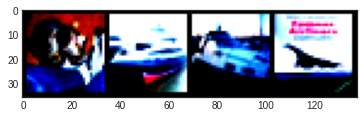

	cat 	ship 	ship 	plane


In [19]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [20]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [21]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [23]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images) # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item() # 맞춘 갯수
    print(100 * correct / total)

77.93


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [24]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane: 75.2%
Accuracy of car: 88.0%
Accuracy of bird: 71.4%
Accuracy of cat: 60.2%
Accuracy of deer: 79.6%
Accuracy of dog: 69.2%
Accuracy of frog: 81.0%
Accuracy of horse: 77.1%
Accuracy of ship: 87.6%
Accuracy of truck: 88.2%
